In [185]:
import GetOldTweets3 as got
import pandas as pd
from functools import reduce
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 
import nltk
import spacy
import re
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
%matplotlib inline

## 0. Scrap 200 twitters per day related to Covid19 

In [19]:
def text_query_to_csv(text_query, count, since_date,until_date):
    # Creation of query object
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(text_query)\
        .setMaxTweets(count).setLang('en')\
        .setSince(since_date).setUntil(until_date)
    # Creation of list that contains all tweets
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)

    # Creating list of chosen tweet data
    text_tweets = [[tweet.date, tweet.text] for tweet in tweets]
    
    # Creation of dataframe from tweets
    return text_tweets
    # Converting tweets dataframe to csv file

In [3]:
from datetime import date
def twitter_to_csv(text_query, count, year, startmonth, endmonth):
    months = np.arange(startmonth,endmonth+1)
    text_tweets = []
    for month in months:
        days = (date(year, month+1, 1) - date(year, month, 1)).days
        for day in range(days):
            since_date = pd.datetime(year,month,day+1).strftime('%Y-%m-%d')
            until_date = (pd.datetime(year,month,day+1)+pd.Timedelta(days=1)\
                         ).strftime('%Y-%m-%d')
            text_tweets += text_query_to_csv(text_query, count, since_date,until_date)
    tweets_df = pd.DataFrame(text_tweets, columns = ['Datetime', 'Text'],\
            index = range(len(text_tweets)))
    tweets_df.to_csv('{}-{}k-{}tweets.csv'.format(text_query,\
                                int(count/1000), year), sep=',')
    

In [ ]:
text_query = 'COVID19'
count = 100
twitter_to_csv(text_query, count,2020,2,7)

# 1. find out most frequent words 

In [2]:
def add_up_words(f):
    def add_up(a,b):
        return a+b
    return reduce(add_up,[f.Text[i] for i in f.index])

In [169]:
def tokens_clean(tokens):
    # remove urls 
    tokens = re.sub(r"http\S+", ' ', tokens)
    # remove symbols 
    tokens = re.sub(r'[^\w]', ' ', tokens)
    # remove numbers
    tokens = re.sub(r'\d', '', tokens)
    tokens = tokens.split()

    # clean stopwords
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer 
    lemmatizer = WordNetLemmatizer() 
    sr= stopwords.words('english')
    
    # of course we should avoid words like covid19, coronavirus
    sr += ['covid19','covid','coronavirus','covid-19','pandemic','amp',\
          'corona','virus','via','wa','ha']
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append(lemmatizer.lemmatize(token).lower())
    clean_tokens = lemma_tokens[:]
    for token in lemma_tokens:
        if token in sr:  
            clean_tokens.remove(token)
        
    return clean_tokens

In [170]:
def plot_frequency(clean_tokens,num):
    #plt.figure(figsize=[10,6])
    freq = nltk.FreqDist(clean_tokens)
    #for key,val in freq.items():
    #     print(str(key) + ':' + str(val)
    freq.plot(10, cumulative=False)
    return freq.most_common(num)

In [171]:
def plot_word_cloud(all_texts,ax):
    # all_texts must be a string 
    covid_wc = WordCloud(
        background_color='white',
        max_words=100,
        width=1000, height=500
        )

    # generate the word cloud
    covid_wc.generate(all_texts)

    # display the word cloud
    ax.imshow(covid_wc, interpolation='bilinear')
    ax.axis('off')


In [333]:
def sentiment_analysis(f):
    attitudes = []
    analyzer = SentimentIntensityAnalyzer()
    for t in f.Text:
        sentences = nltk.sent_tokenize(t)
        hashtag = {'pos':0, 'neg':0, 'neu':0}
        for sentence in sentences:
            vs = analyzer.polarity_scores(sentence)
            vs.pop('compound')
            attitude = max(vs.items(),key = lambda x: x[1])[0]
            hashtag[attitude] += 1
        if hashtag['neg'] == hashtag['pos']:
            attitudes.append('neu')
        elif hashtag['neg'] > hashtag['pos']:
            attitudes.append('neg')
        else:
            attitudes.append('pos')
    return attitudes

In [119]:
f1 = pd.read_csv('COVID19-0k-2020tweets.csv',index_col=[0],parse_dates=[1])
f2 = pd.read_csv('coronavirus-0k-2020tweets.csv',index_col=[0],parse_dates=[1])
f = pd.concat([f1,f2], ignore_index=True)


In [172]:
clean_tokens = []
for i in range(6):
    tokens = add_up_words(f.loc[f.Datetime.dt.month==i+2])
    clean_tokens += [tokens_clean(tokens)]

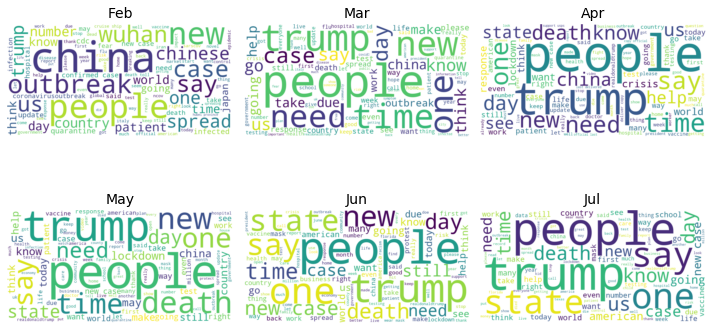

In [173]:
fig,axs = plt.subplots(2,3,figsize=[10,6])
axs = axs.flatten()
titles = ['Feb','Mar','Apr','May','Jun','Jul']
for i in range(6):
    all_texts = ' '.join(clean_tokens[i])
    plot_word_cloud(all_texts,axs[i])
    axs[i].set_title(titles[i],fontsize=14)
plt.tight_layout()
#plt.savefig('/sn2/wyu/research/temporary/monthly_keywords.pdf')

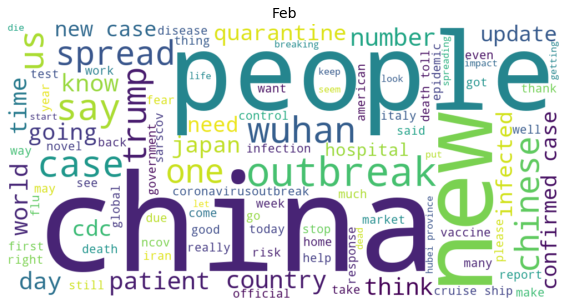

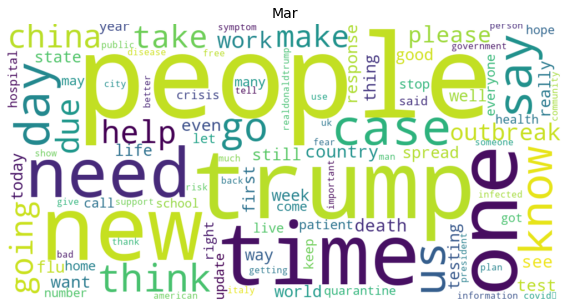

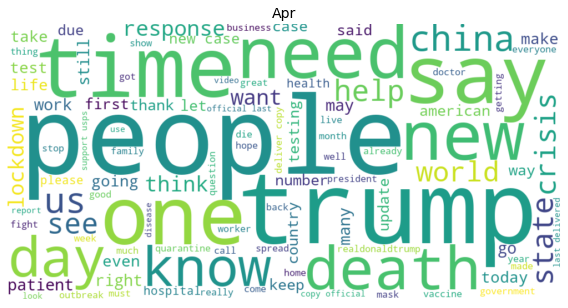

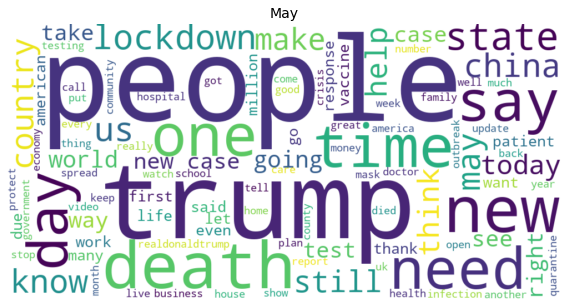

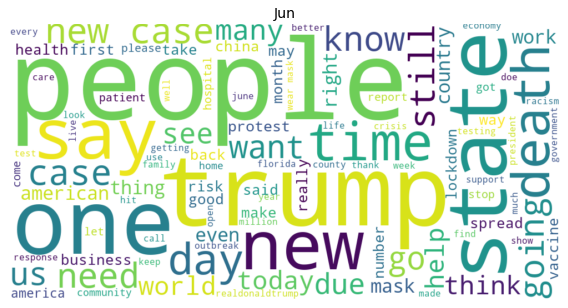

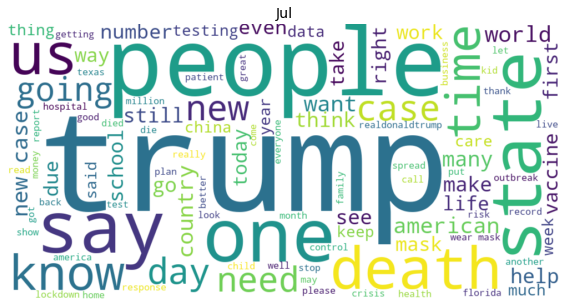

In [174]:
titles = ['Feb','Mar','Apr','May','Jun','Jul']
for i in range(6):
    all_texts = ' '.join(clean_tokens[i])
    fig = plt.figure(figsize=[8,5])
    plot_word_cloud(all_texts,fig.gca())
    fig.gca().set_title(titles[i],fontsize=14)
    plt.tight_layout()
    plt.savefig('images/keyword_'+titles[i]+'.png')

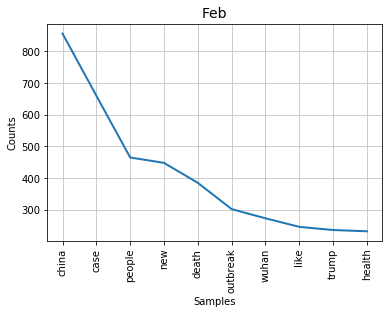

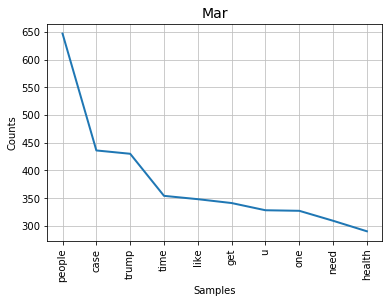

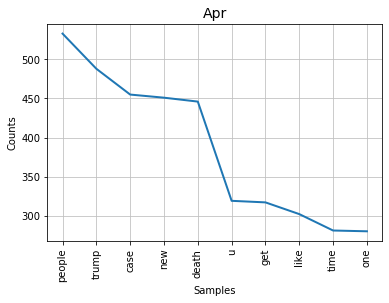

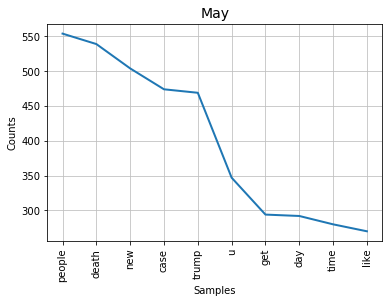

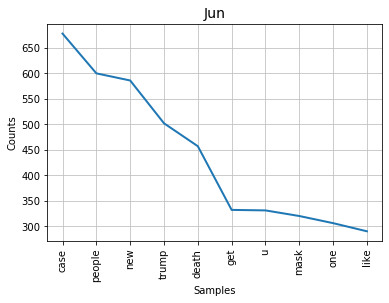

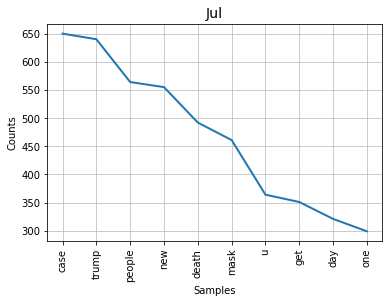

<Figure size 432x288 with 0 Axes>

In [175]:
titles = ['Feb','Mar','Apr','May','Jun','Jul']
most_common_months = []
for i in range(6):
    all_texts = ' '.join(clean_tokens[i])
    plt.title(titles[i],fontsize=14) 
    most_common_months += [plot_frequency(clean_tokens[i],500)]  
    plt.tight_layout()
    


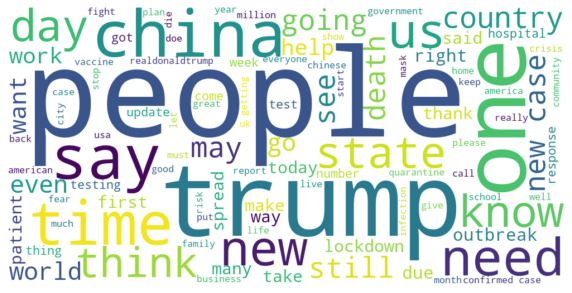

In [176]:
clean_tokens_all = reduce(lambda x,y: x+y, clean_tokens)
fig = plt.figure(figsize=[10,6])
plot_word_cloud(' '.join(clean_tokens_all),fig.gca())
plt.savefig('images/keyword.png')

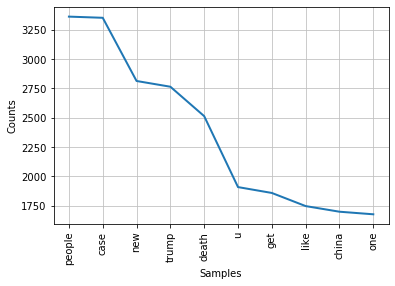

In [177]:
# find out most frequent words 
most_common = plot_frequency(clean_tokens_all,500)  

In [199]:
clean_tokens = []
for tokens in f.Text:
    clean_tokens += [' '.join(tokens_clean(tokens))]
f['Clean_Text'] = clean_tokens

In [227]:
from collections import defaultdict
words_frequency = defaultdict(list)

In [228]:
words = [x[0] for x in most_common]
for word in words:
    for frequencys in most_common_months:
        flag = 0
        for frequency in frequencys:
            if frequency[0] == word:
                words_frequency[word].append(frequency[1])
                flag = 1
                break
        if flag == 0:
            words_frequency[word].append(0)

In [229]:
words_frequency

defaultdict(list,
            {'people': [465, 647, 533, 554, 600, 564],
             'case': [660, 436, 455, 474, 678, 650],
             'new': [448, 270, 451, 504, 586, 555],
             'trump': [236, 430, 488, 469, 502, 640],
             'death': [385, 195, 446, 539, 457, 492],
             'u': [220, 328, 319, 347, 331, 364],
             'get': [224, 341, 317, 294, 332, 351],
             'like': [246, 348, 302, 270, 290, 291],
             'china': [856, 184, 213, 196, 126, 124],
             'one': [196, 327, 280, 269, 306, 299],
             'time': [147, 354, 281, 280, 267, 266],
             'day': [185, 259, 260, 292, 269, 321],
             'say': [216, 236, 259, 253, 253, 266],
             'health': [232, 290, 226, 240, 230, 233],
             'news': [211, 195, 189, 269, 222, 265],
             'need': [144, 309, 248, 231, 202, 198],
             'know': [163, 247, 243, 201, 198, 221],
             'us': [216, 204, 219, 218, 166, 245],
             'mask': [73, 92, 1

In [524]:
important_keywords = ['cases','trump','us','death','china','mask'\
        ,'public','hospital','lockdown']

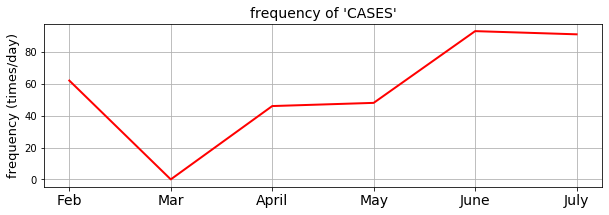

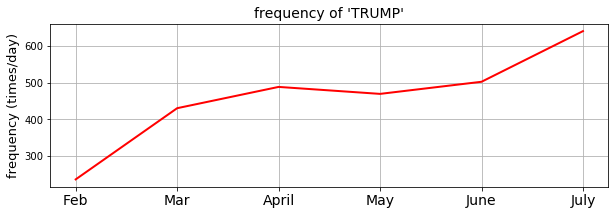

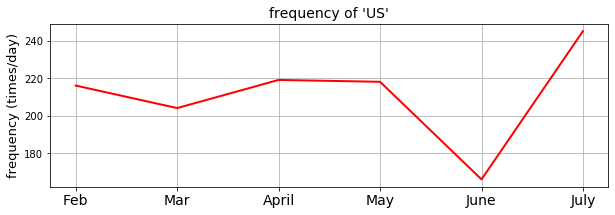

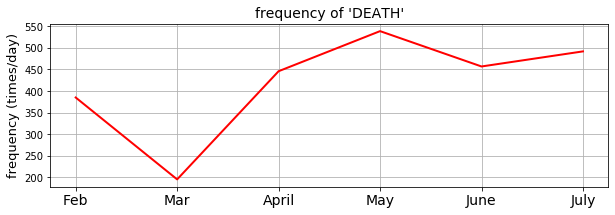

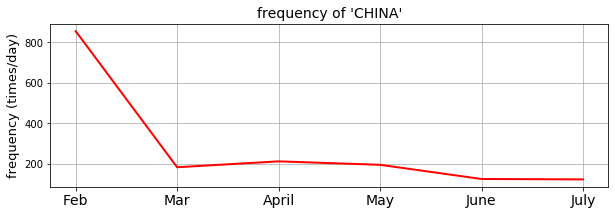

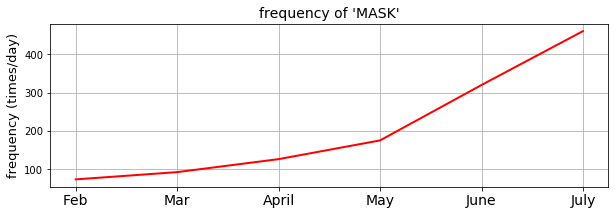

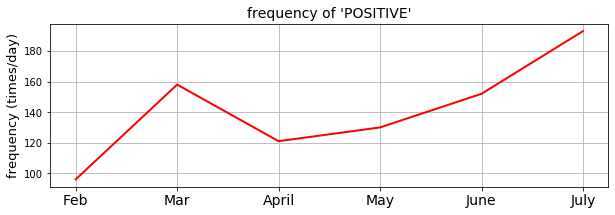

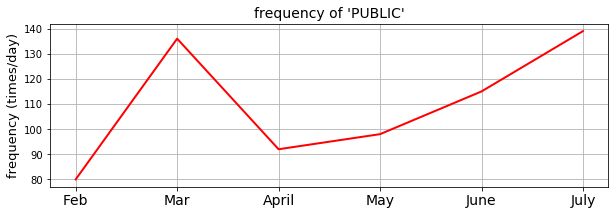

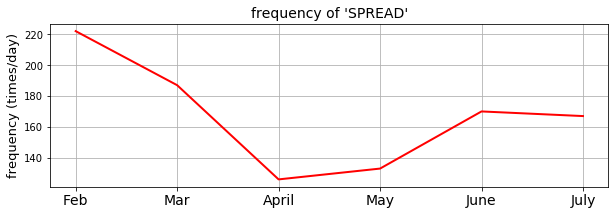

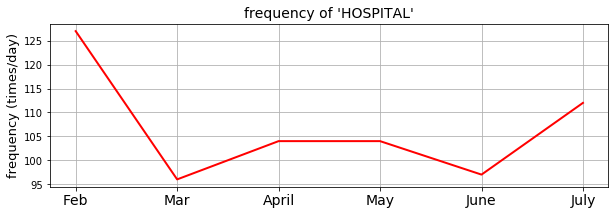

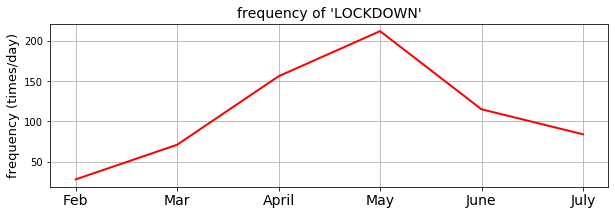

In [230]:
for keywords in important_keywords:
    plt.figure(figsize=[10,3])
    plt.plot(words_frequency[keywords],'r',linewidth=2)
    plt.title('frequency of \''+ keywords.upper()+'\'', fontsize=14)
    plt.xticks(range(6),['Feb','Mar','April',
        'May','June','July'],fontsize=14)
    plt.ylabel('frequency (times/day)',fontsize=13)
    plt.grid()
    #plt.savefig('images/frequency_'+keywords+'.png')

In [406]:
f['Sentiment'] = sentiment_analysis(f)

0.9161367096315842

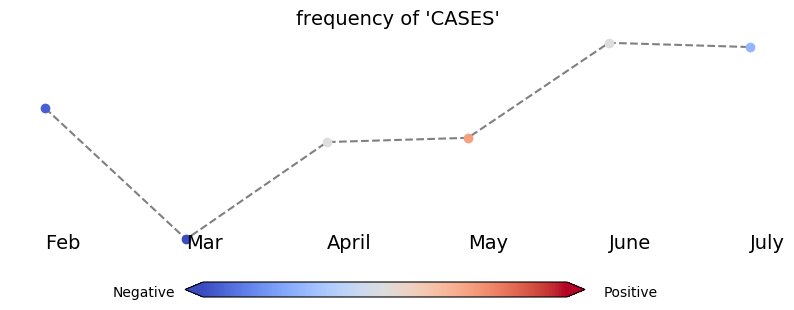

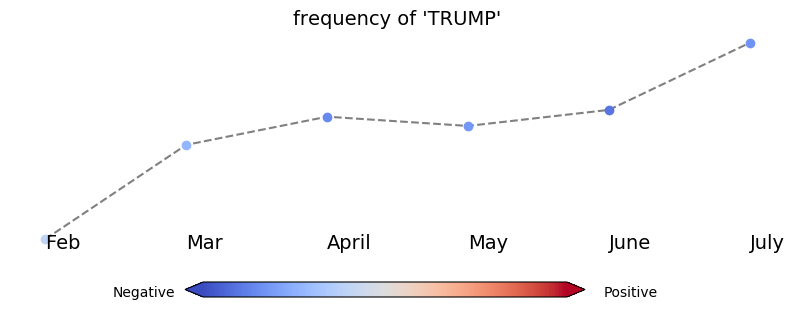

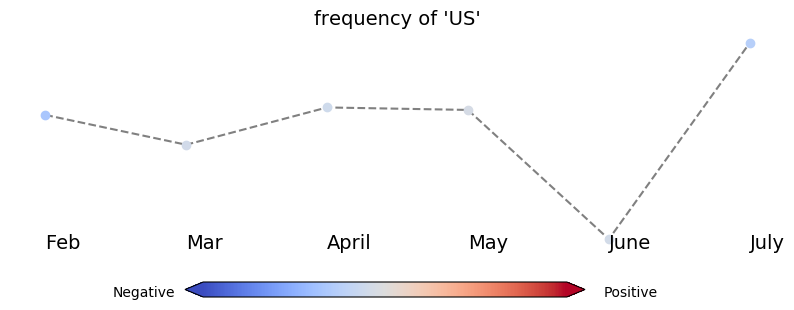

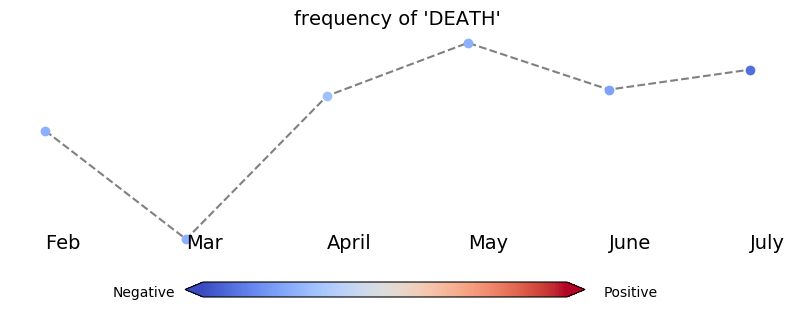

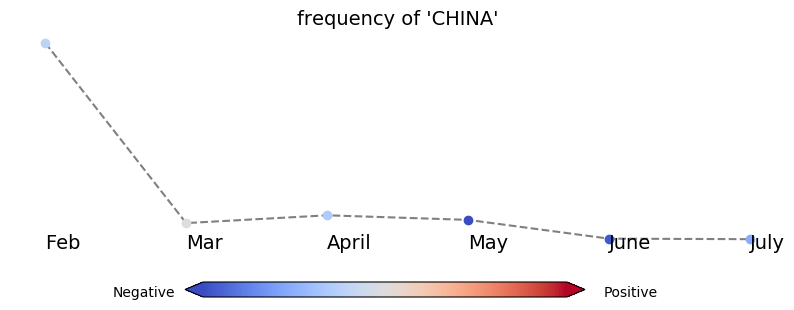

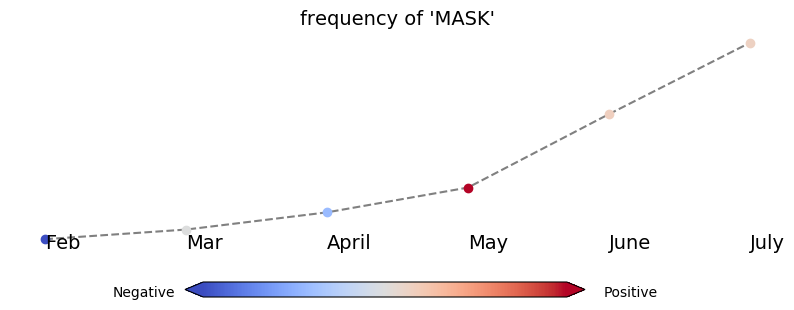

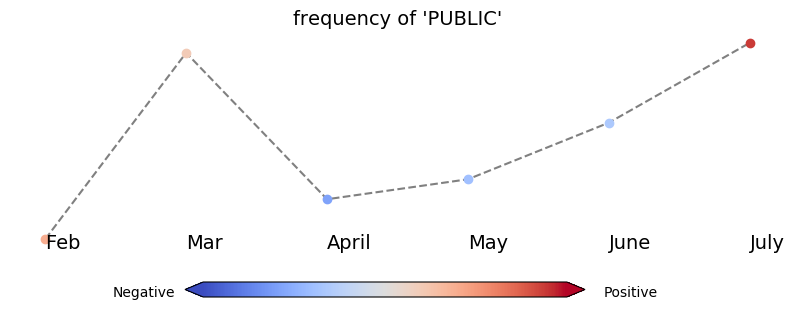

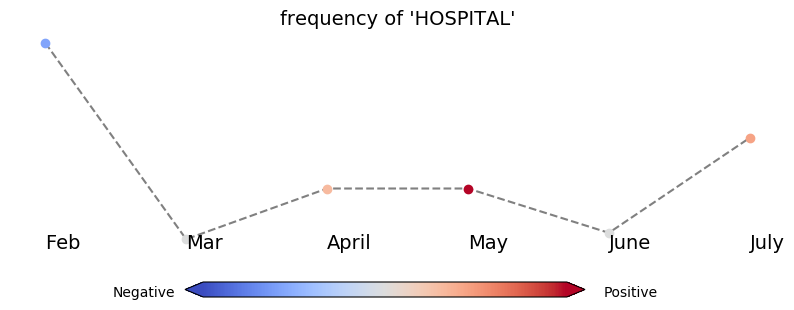

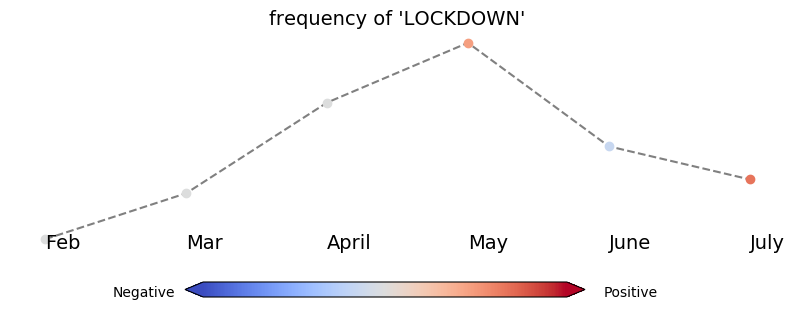

In [526]:
for keywords in important_keywords:
    fig = plt.figure(figsize=[10,3])
    f_keyword = f.iloc[[keywords in t for t in f.Clean_Text]]
    ff = f_keyword.Sentiment.groupby([f.Datetime.dt.month, f.Sentiment])\
    .count()
    idx = pd.MultiIndex.from_product([ff.index.levels[0],ff.index.levels[1]])
    f_sentiment_month = ff.to_frame('count_a').reindex(idx, fill_value=0)
    pos = f_sentiment_month[['pos' in index for index in f_sentiment_month.index]].count_a.values
    neg = f_sentiment_month[['neg' in index for index in f_sentiment_month.index]].count_a.values
    neu = f_sentiment_month[['neu' in index for index in f_sentiment_month.index]].count_a.values
    plt.plot(words_frequency[keywords],'grey',linestyle='--')
    #plt.plot(,'o')
    plt.title('frequency of \''+ keywords.upper()+'\'', fontsize=14)
    for i in range(6):
        plt.text(i,fig.gca().get_ylim()[0],['Feb','Mar','April',
        'May','June','July'][i],fontsize=14)
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    import matplotlib.colorbar as colorbar
    cmap = cm.coolwarm
    vmin = 0.9
    vmax = 1.1
    v = (pos+(neu/2))/(neg+(neu/2))
    colors_array = cmap((v-vmin)/(vmax-vmin))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    my_levels = np.linspace(vmin,vmax,11)
    for i in range(6):
        plt.plot(i,words_frequency[keywords][i],'o',color=rainbow[i]) 
    plt.ylabel('times',fontsize=13)
    fig.gca().set_axis_off()
    plt.subplots_adjust(bottom=0.16)
    cax = plt.axes([0.3, 0., 0.4, 0.05])
    cax.set_axis_off()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cb1 = colorbar.ColorbarBase(cax, cmap=cmap,norm=norm ,orientation ='horizontal',extend='both')
    #cb1.set_label('Negative '+' '*20+' Neutral'+' '*20+'Positive',fontsize=12)
    plt.text(0.85,cax.get_ylim()[0],'Negative')
    plt.text(1.12,cax.get_ylim()[0],'Positive')
    plt.savefig('images/frequency_'+keywords+'.png')

In [487]:
plt.style.use('default')